Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87     15196
           1       0.62      0.39      0.48      4804

    accuracy                           0.80     20000
   macro avg       0.72      0.66      0.68     20000
weighted avg       0.78      0.80      0.78     20000

Confusion Matrix:
 [[14055  1141]
 [ 2942  1862]]

Logistic Regression Coefficients (sorted by magnitude):
                              Feature  Coefficient
11                Product Name_Router     0.041150
8                 Product Name_Laptop     0.020555
4                          Product ID     0.009229
6             Product Name_Headphones     0.004467
13            Product Name_Smartwatch    -0.003643
1                      Total Sessions    -0.004260
10               Product Name_Printer    -0.007331
5                            Gender_M    -0.008944
12            Product Name_Smartphone    -0.039997
14                Product Name_T

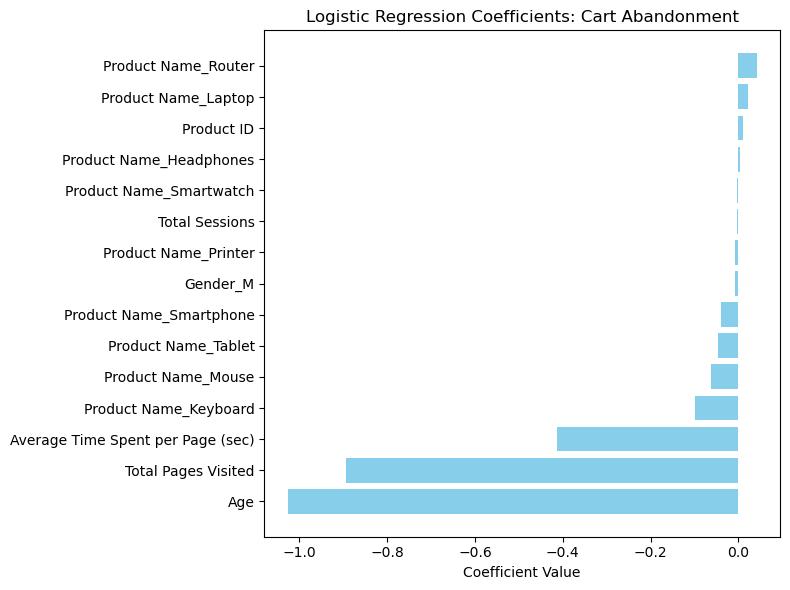

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


# 1. Load Dataset

df = pd.read_csv('eledget_single_dataset_stronger_patterns.csv')


# 2. Drop Unused Columns (They occur after cart abandonment)

unused_cols = [
    'Shipping Method',
    'Payment Method',
    'Transaction Success',
    'Transaction Amount',
    'Feedback Given'
]
df.drop(columns=unused_cols, inplace=True)


# 3. Prepare Target & Features

# Convert 'Cart Abandoned' from Yes/No to 1/0
df['Cart Abandoned'] = df['Cart Abandoned'].map({'Yes': 1, 'No': 0})

# Separate target and features
y = df['Cart Abandoned']
X = df.drop('Cart Abandoned', axis=1)


# 4. Identify Numeric & Categorical Columns

numeric_features = ['Age', 'Total Sessions', 'Total Pages Visited', 'Average Time Spent per Page (sec)', 'Product ID']
categorical_features = ['Gender', 'Product Name']


# 5. Create a Preprocessing + Modeling Pipeline

# OneHotEncode the categorical columns; scale numeric columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

# Define Logistic Regression model
logreg = LogisticRegression(solver='liblinear', random_state=42)

# Combine into a single pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', logreg)
])


# 6. Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# 7. Fit and evaluate the Model 

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


# 8. Extract & Display Coefficients

# Get the feature names from the ColumnTransformer
encoded_cat_features = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(encoded_cat_features)

# Get the coefficients from the logistic regression
coefficients = pipeline.named_steps['logreg'].coef_[0]

# Pair each coefficient with its corresponding feature name
feature_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

print("\nLogistic Regression Coefficients (sorted by magnitude):")
print(feature_importance)


# 9. Plot the Coefficients

plt.figure(figsize=(8, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='skyblue')
plt.xlabel("Coefficient Value")
plt.title("Logistic Regression Coefficients: Cart Abandonment")
plt.gca().invert_yaxis()  # Highest coefficient at top
plt.tight_layout()
plt.show()
